# **Competency 2 Project 2: Rex Craft**

This model aims to predict diabetes in patients ages 18-90.This project builds on the model from project 1, modifying it to include custom loss and activation functions.

## Imports

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Dataset Download
Dataset: [Diabetes Dataset](https://www.kaggle.com/datasets/asinow/diabetes-dataset)  
*This dataset contains 9,538 medical records related to diabetes diagnosis and risk factors. It includes various health parameters, lifestyle habits, and genetic predispositions that contribute to diabetes risk.*

In [1]:
import kagglehub

path = kagglehub.dataset_download("asinow/diabetes-dataset")

print("Path to dataset files:", path)

100%|██████████| 224k/224k [00:00<00:00, 27.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/asinow/diabetes-dataset/versions/1


In [2]:
# Path to csv
dataset_path = path + '/diabetes_dataset.csv'

## Convert to DataFrame

### Kaggle Dataset

In [5]:
data_kaggle = pd.read_csv(dataset_path)
data_kaggle.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


### Synthetic Dataset
  
This function generates a synthetic dataset containing only positive diabetes diagnoses by randomly sampling health-related attributes within realistic ranges and filtering rows where:  

- BMI ≥ 25
- Glucose ≥ 126
- HbA1c ≥ 6.5.
- FamilyHistory = 0
- Outcome = 1

This ensures that every entry meets at least one diagnostic criteria for diabetes. The synthetic data can be used to supplement the existing dataset, in order to address class imbalance where negative cases significantly outnumber positive cases.

In [6]:
def generate_dataset(n):
    np.random.seed(42)

    data = []

    while len(data) < n:
        age = np.random.randint(18, 91)
        pregnancies = np.random.randint(0, 11)
        bmi = np.random.uniform(15, 50)
        glucose = np.random.uniform(50, 200)
        blood_pressure = np.random.uniform(60, 140)
        hba1c = np.random.uniform(4.0, 7.0)
        ldl = np.random.uniform(1, 100)
        hdl = np.random.uniform(1, 100)
        triglycerides = np.random.uniform(50, 350)
        waist_circumference = np.random.uniform(20, 40)
        hip_circumference = np.random.uniform(20, 40)
        whr = waist_circumference / hip_circumference
        family_history = np.random.randint(0,2)
        diet_type = np.random.randint(0, 3)
        hypertension = np.random.randint(0, 2)
        medication_use = np.random.randint(0, 2)

        outcome = int((bmi >= 25) or (glucose >= 126) or (hba1c >= 6.5))

        if outcome == 1:
            data.append([age, pregnancies, bmi, glucose, blood_pressure, hba1c, ldl, hdl, triglycerides,
                         waist_circumference, hip_circumference, whr, family_history, diet_type, hypertension,
                         medication_use, outcome])

    columns = ["Age", "Pregnancies", "BMI", "Glucose", "BloodPressure", "HbA1c", "LDL", "HDL",
               "Triglycerides", "WaistCircumference", "HipCircumference", "WHR", "FamilyHistory",
               "DietType", "Hypertension", "MedicationUse", "Outcome"]

    df = pd.DataFrame(data, columns=columns)

    return df

### Generate dataset

In [7]:
data_synthetic = generate_dataset(3000)
data_synthetic.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,10,42.289185,139.527524,95.666620,4.299925,46.465640,34.037153,92.860045,33.017769,21.128232,1.562732,1,1,1,1,1
1,81,4,36.611853,141.747974,60.565304,4.069187,52.952691,40.586236,63.999699,39.475110,24.655427,1.601072,1,2,1,0,1
2,72,3,35.734510,56.967562,108.603588,4.511572,7.440108,94.939668,339.689610,36.167947,26.092275,1.386155,0,1,1,1,1
3,77,6,36.349883,174.979237,73.869172,5.173182,19.041373,75.780780,177.546762,24.158833,31.354007,0.770518,0,2,1,1,1
4,61,1,28.830258,188.998830,118.181760,4.979622,57.473953,52.562592,338.351607,36.890677,34.946402,1.055636,0,0,1,1,1


### Combine Datasets

In [8]:
data = pd.concat([data_kaggle, data_synthetic], ignore_index=True)
data.shape

(12538, 17)

## Visualizing the Data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12538 entries, 0 to 12537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 12538 non-null  int64  
 1   Pregnancies         12538 non-null  int64  
 2   BMI                 12538 non-null  float64
 3   Glucose             12538 non-null  float64
 4   BloodPressure       12538 non-null  float64
 5   HbA1c               12538 non-null  float64
 6   LDL                 12538 non-null  float64
 7   HDL                 12538 non-null  float64
 8   Triglycerides       12538 non-null  float64
 9   WaistCircumference  12538 non-null  float64
 10  HipCircumference    12538 non-null  float64
 11  WHR                 12538 non-null  float64
 12  FamilyHistory       12538 non-null  int64  
 13  DietType            12538 non-null  int64  
 14  Hypertension        12538 non-null  int64  
 15  MedicationUse       12538 non-null  int64  
 16  Outc

In [10]:
data.describe()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
count,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000,12538.000000
mean,53.459244,7.274765,28.692994,111.914213,88.312382,4.860010,88.341051,50.161646,163.267950,78.647582,85.556126,0.947283,0.350455,0.611501,0.122827,0.429813,0.501037
std,20.842894,4.740792,7.567125,30.304878,18.047666,0.708079,36.331677,19.307173,63.632623,30.622822,33.458447,0.196244,0.477131,0.736725,0.328251,0.495069,0.500019
min,18.000000,0.000000,15.000000,50.000000,60.000000,4.000000,-12.000000,-9.200000,50.000000,20.006142,20.000962,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,3.000000,23.420000,91.200000,75.000000,4.300000,66.000000,38.000000,118.900000,60.525000,73.700000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,7.000000,27.970000,109.000000,86.000000,4.700000,90.537292,50.300000,156.450000,87.400000,97.700000,0.920000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,72.000000,11.000000,33.000000,128.500000,99.000000,5.200000,113.100000,62.200000,199.300000,101.100000,109.075000,1.040000,1.000000,1.000000,0.000000,1.000000,1.000000
max,90.000000,16.000000,49.993180,207.200000,139.983150,6.998632,202.200000,107.800000,349.942544,163.000000,156.600000,1.982311,1.000000,2.000000,1.000000,1.000000,1.000000


In [11]:
# Check for null vlaues
data.isnull().sum()

,0
Age,0
Pregnancies,0
BMI,0
Glucose,0
BloodPressure,0
HbA1c,0
LDL,0
HDL,0
Triglycerides,0
WaistCircumference,0


### Correlation Matrices

This chart shows how different health factors relate to each other and to the outcome. Darker red means a strong positive link, while blue means a negative one. Things like **HbA1c, glucose, waist size, family history, and hypertension** are more connected to the outcome, meaning they might play a big role in predicting it. On the other hand, **hip size and LDL** seem to have the opposite effect. Some factors are strongly related, while others don’t matter much.

<Axes: >

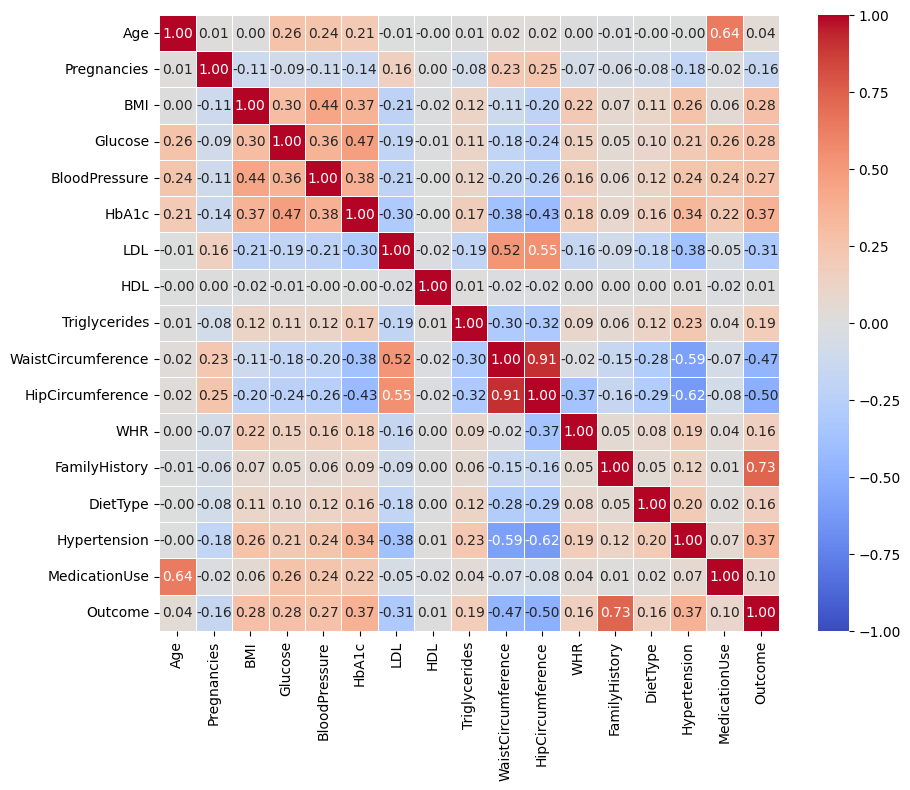

In [12]:
import seaborn as sns

corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

Dropping highly uncorrelated features

<Axes: >

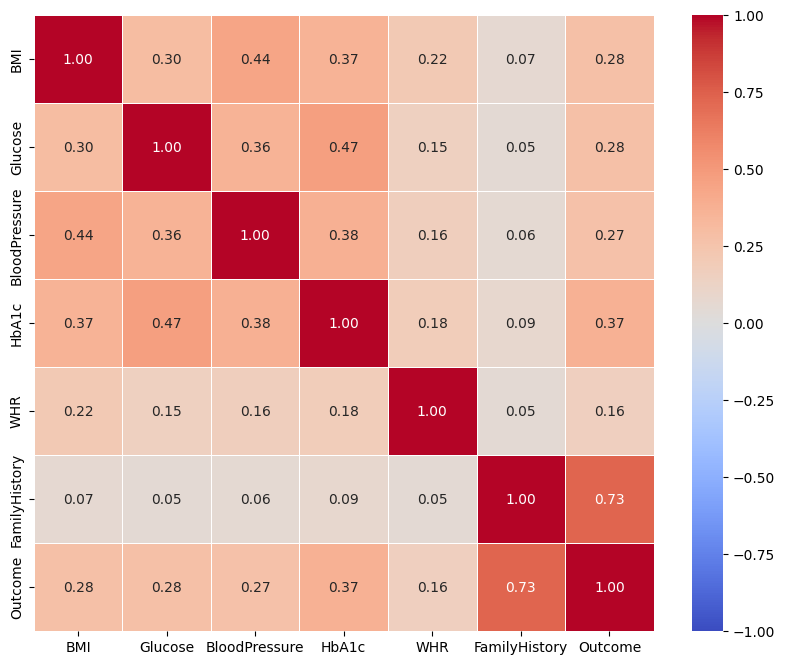

In [18]:
data_condensed = data.drop(columns=['Age', 'DietType', 'Hypertension',
                                    'Triglycerides', 'HDL', 'LDL', 'Pregnancies',
                                    'WaistCircumference', 'HipCircumference',
                                    'MedicationUse'])

corr_matrix = data_condensed.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

Adding categorical features to better support the target

### *Note: Family History Feature*
I decided to drop Family History for this model as it was too highly correlated to diabetic outcome. Instead I created a new feature combining:

- Glucose Category
- BMI Category
- HbA1c Category
- Family History

<Axes: >

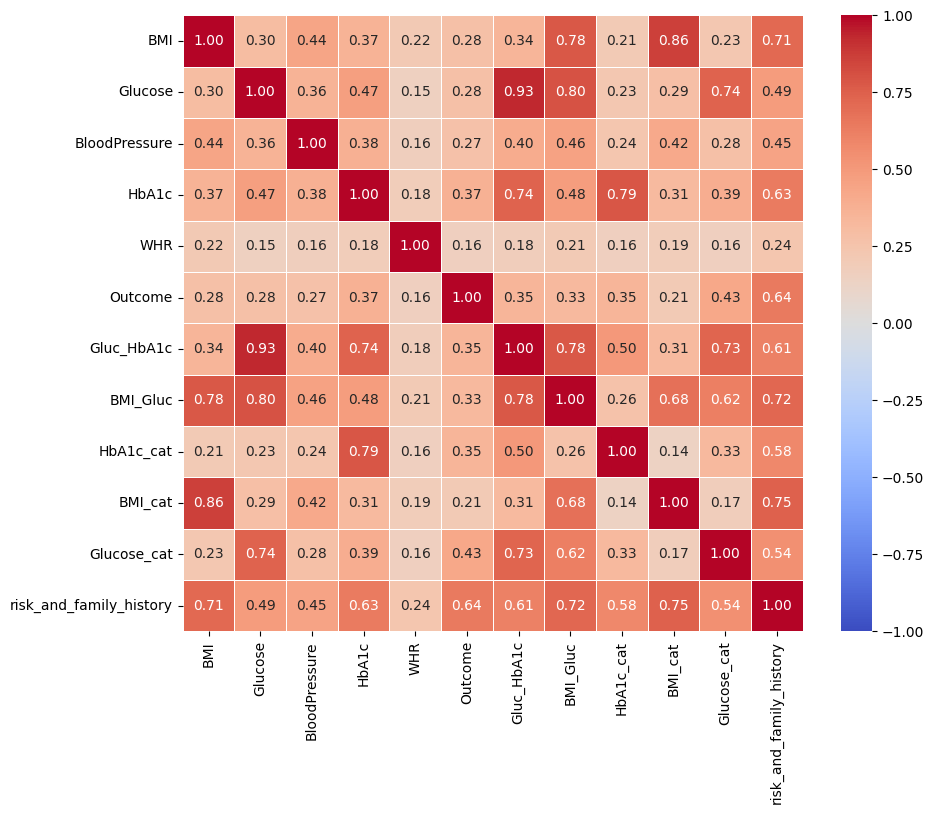

In [19]:
data_condensed['Gluc_HbA1c'] = data_condensed['Glucose'] * data_condensed['HbA1c']
data_condensed['BMI_Gluc'] = data_condensed['BMI'] * data_condensed['Glucose']

a1c_bins = [0.0, 5.7, 6.4, 7.0]
a1c_labels = [0, 1, 2]
data_condensed['HbA1c_cat'] = pd.cut(data_condensed['HbA1c'], bins=a1c_bins, labels=a1c_labels, right=False)

bmi_bins = [0, 25, 30, 50]
bmi_labels = [0, 1, 2]
data_condensed['BMI_cat'] = pd.cut(data['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

gluc_bins = [0, 140, 199, 300]
gluc_labels = [0, 1, 2]
data_condensed['Glucose_cat'] = pd.cut(data_condensed['Glucose'], bins=gluc_bins, labels=gluc_labels, right=False)

data_condensed['risk_and_family_history'] = data_condensed['HbA1c_cat'].astype(int) + data_condensed['BMI_cat'].astype(int) + data_condensed['Glucose_cat'].astype(int) + data_condensed['FamilyHistory']
data_condensed['risk_and_family_history'] = data_condensed['risk_and_family_history'] / data_condensed['risk_and_family_history'].max()

data_condensed.drop(columns=['FamilyHistory'], inplace=True)

corr_matrix = data_condensed.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

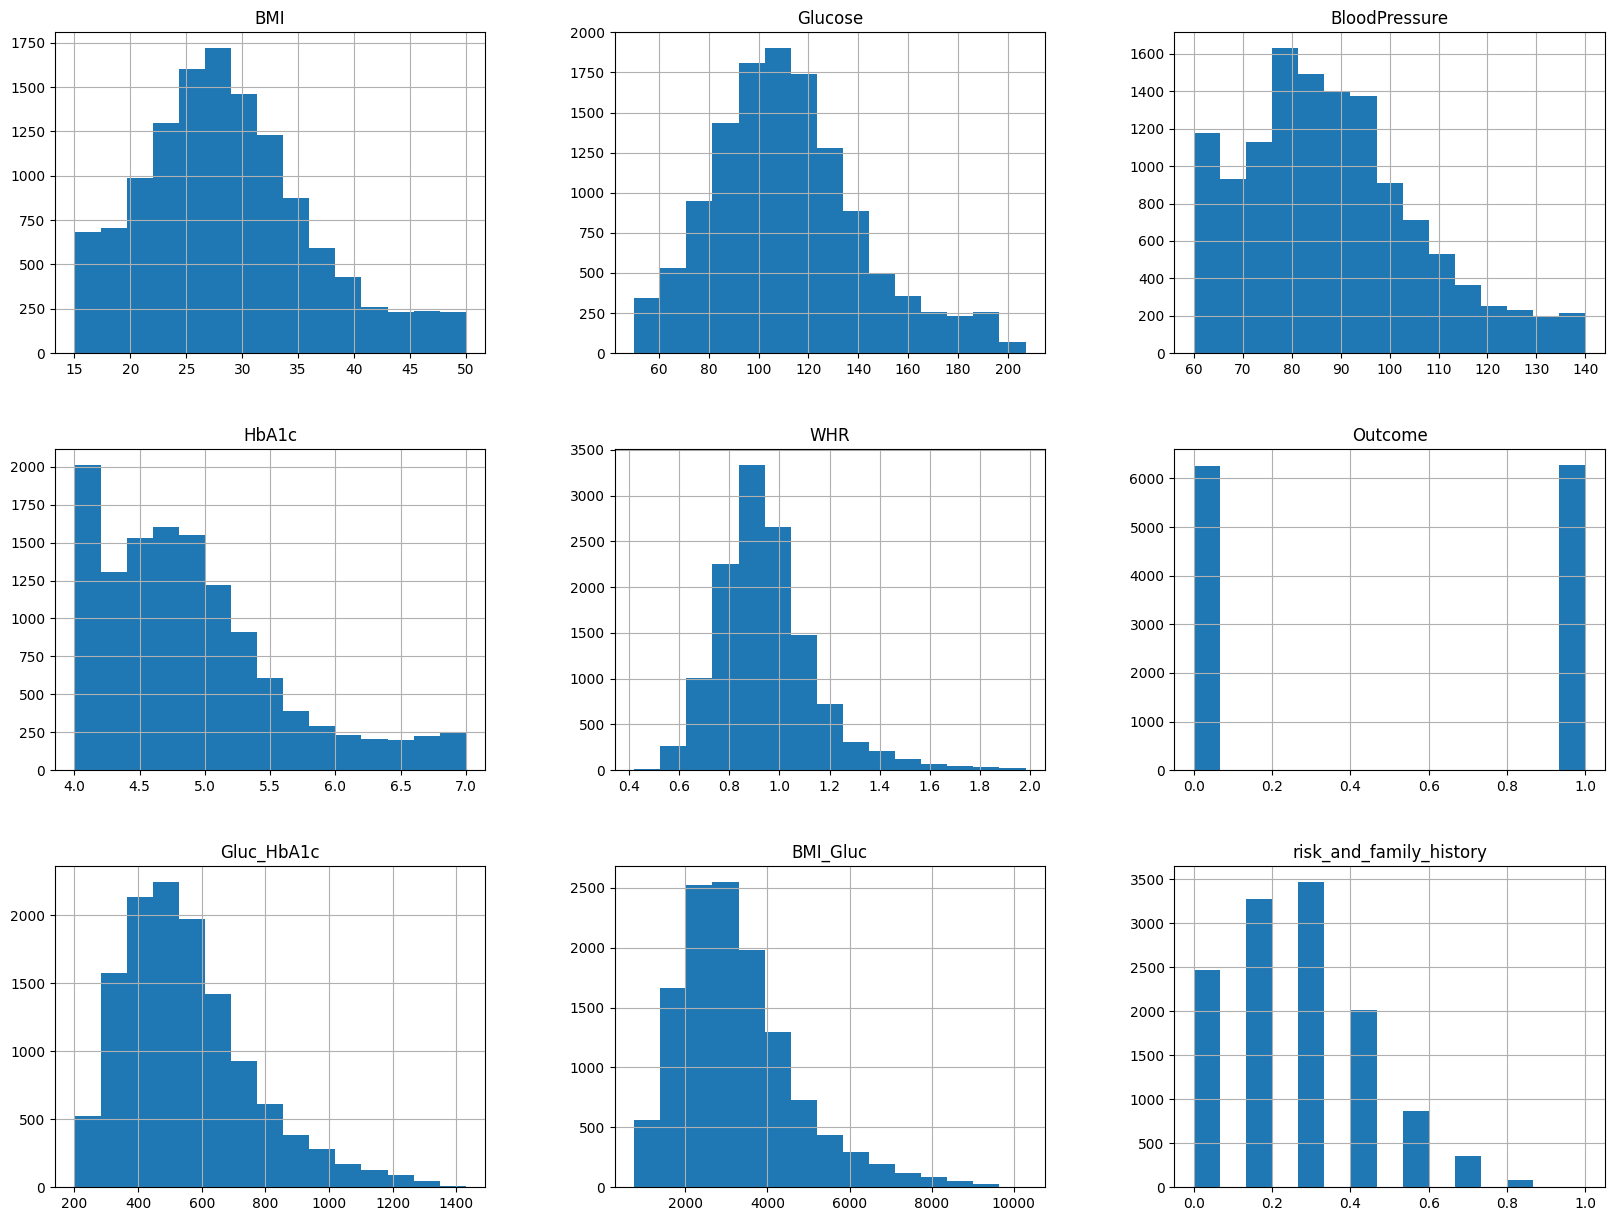

In [20]:
data_condensed.hist(bins=15, figsize=(20,15))
plt.show()

# Data Preprocessing

This preprocessing function prepares the dataset by removing less relevant features and engineering new ones to enhance predictive power. We create interaction terms like `Gluc_HbA1c` and `BMI_Gluc` to capture potential relationships between glucose, HbA1c, and BMI. Continuous variables such as HbA1c, BMI, and Glucose are categorized into bins for better feature representation. The dataset is then split into training, validation, and test sets to ensure proper model evaluation. Finally, we apply standardization using StandardScaler to normalize feature distributions.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocessing(df):
    df = df.drop(columns=['DietType', 'Triglycerides', 'HDL', 'Pregnancies',
                          'WaistCircumference', 'HipCircumference', 'LDL', 'WHR',
                          'Hypertension', 'MedicationUse'])
    df['Gluc_HbA1c'] = df['Glucose'] * df['HbA1c']
    df['BMI_Gluc'] = df['BMI'] * df['Glucose']

    a1c_bins = [0.0, 5.7, 6.5, 7.0]
    a1c_labels = [0, 1, 2]
    df['HbA1c_cat'] = pd.cut(df['HbA1c'], bins=a1c_bins, labels=a1c_labels, right=False)

    bmi_bins = [0, 25, 30, 50]
    bmi_labels = [0, 1, 2]
    df['BMI_cat'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

    gluc_bins = [0, 140, 199, 300]
    gluc_labels = [0, 1, 2]
    df['Glucose_cat'] = pd.cut(df['Glucose'], bins=gluc_bins, labels=gluc_labels, right=False)

    df['risk_and_family_history'] = df['HbA1c_cat'].astype(int) + df['BMI_cat'].astype(int) + df['Glucose_cat'].astype(int) + df['FamilyHistory']
    df['risk_and_family_history'] = df['risk_and_family_history'] / df['risk_and_family_history'].max()

    df = df.drop(columns=['FamilyHistory', 'HbA1c', 'BMI', 'Age', 'Glucose'])

    X = df.drop(columns=['Outcome'])
    y = df['Outcome']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


### Defining Features and Target
Splitting the data into features and target frames.

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(data)

# DNN Model

## Custom Loss Function

This function creates a custom loss for a classification model. It’s based on **focal loss**, which helps the model focus more on hard-to-classify cases. It also **balances class differences**, so one class doesn’t dominate learning. The loss is based on standard binary cross-entropy but adds extra weighting to give more attention to mistakes. It also prevents math errors by keeping probabilities within a safe range.

In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

class CustomLoss(Loss):
    def __init__(self, focusing_factor=2.0, class_balance=0.25, name="custom_loss"):
        super().__init__(name=name)
        self.focusing_factor = focusing_factor
        self.class_balance = class_balance

    def call(self, true_labels, predicted_probs):
        epsilon = K.epsilon()
        predicted_probs = K.clip(predicted_probs, epsilon, 1.0 - epsilon)

        binary_crossentropy = - (
            true_labels * K.log(predicted_probs) + (1 - true_labels) * K.log(1 - predicted_probs)
        )

        correct_class_prob = true_labels * predicted_probs + (1 - true_labels) * (1 - predicted_probs)

        focal_weight = self.class_balance * K.pow(1 - correct_class_prob, self.focusing_factor)

        loss = focal_weight * binary_crossentropy
        return K.mean(loss)


## Custom Activation Function

This function defines a custom activation layer that helps improve learning and stability. During training, it adds a small amount of random noise to the input, making the model more adaptable to new data. It then applies a modified activation function that smooths values using the sigmoid function while keeping activations controlled. To prevent extreme outputs, it includes a small penalty that reduces large values and ensures that the final output stays within a range of -5 to 5. This combination helps the model generalize better and remain stable during training.

In [24]:
from tensorflow.keras.layers import Layer

class CustomActivation(Layer):
    def __init__(self, noise_stddev=0.05, l2_penalty=0.01):
        super(CustomActivation, self).__init__()
        self.noise_stddev = noise_stddev
        self.l2_penalty = l2_penalty

    def call(self, inputs, training=False):
        if training:
            inputs = inputs + K.random_normal(shape=K.shape(inputs),
                                              mean=0.0,
                                              stddev=self.noise_stddev)

        activated = inputs * K.sigmoid(inputs)

        regularized = activated - self.l2_penalty * K.square(activated)

        return K.clip(regularized, -5.0, 5.0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "noise_stddev": self.noise_stddev,
            "l2_penalty": self.l2_penalty
        })
        return config

## Defining Layers

This neural network is designed for binary classification, utilizing a deep architecture with progressively increasing and then decreasing layer sizes to capture complex patterns in the data. Each dense layer employs L2 regularization to mitigate overfitting, while ReLU activations ensure non-linearity. Batch normalization and dropout are introduced in deeper layers to stabilize training and enhance generalization. The final output layer uses a sigmoid activation, making the model suitable for predicting probabilities in a binary classification task.

In [25]:
K.clear_session()

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

model = Sequential([
    Dense(8, activation=CustomActivation(), input_shape=(X_train.shape[1],)),
    Dense(16, activation=CustomActivation()),
    Dense(32, activation=CustomActivation()),
    BatchNormalization(),
    Dropout(0.003),
    Dense(64, activation=CustomActivation()),
    BatchNormalization(),
    Dense(32, activation=CustomActivation()),
    BatchNormalization(),
    Dropout(0.003),
    Dense(16, activation=CustomActivation()),
    Dense(8, activation=CustomActivation()),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Layers

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,129 (23.94 KB)

 Trainable params: 5,873 (22.94 KB)

 Non-trainable params: 256 (1.00 KB)

## Compiling the Model

We're using `Adam` as the optimizer and the customer loss function `CustomLoss` as the loss function.

In [28]:
model.compile(optimizer='adam', loss=CustomLoss(), metrics=['accuracy'])

# Training the Model

The model is trained using the provided training set with a validation set to monitor performance and prevent overfitting. We use 40 epochs and a batch size of 64 to balance convergence speed and generalization. The validation data helps assess the model’s ability to generalize beyond the training set, guiding potential adjustments in hyperparameters or architecture if necessary.

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=64)

Epoch 1/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7860 - loss: 0.0285 - val_accuracy: 0.8028 - val_loss: 0.0327
Epoch 2/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9521 - loss: 0.0103 - val_accuracy: 0.8671 - val_loss: 0.0181
Epoch 3/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9641 - loss: 0.0073 - val_accuracy: 0.9623 - val_loss: 0.0090
Epoch 4/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9757 - loss: 0.0059 - val_accuracy: 0.9676 - val_loss: 0.0067
Epoch 5/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9728 - loss: 0.0063 - val_accuracy: 0.9697 - val_loss: 0.0066
Epoch 6/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9730 - loss: 0.0058 - val_accuracy: 0.9702 - val_loss: 0.0066
Epoch 7/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9744 - loss: 0.0060 - val_accuracy: 0.9692 - val_loss: 0.0064
Epoch 8/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9729 - loss: 0.0060 - val_accuracy: 0.

# Model Evaluation

## Test Set Performance

The model's performance is assessed on the test set to measure its generalization ability. The final test accuracy of 97.77% indicates strong predictive capability, suggesting effective feature engineering and model architecture. If needed, further tuning or additional data augmentation could be explored to refine performance.

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.0059
Test Accuracy: 0.9777


## Classification Report

The model’s predictions are binarized using a threshold of 0.5 and evaluated using precision, recall, and F1-score. The classification report shows a balanced performance across both classes, with precision and recall values near 0.98 and an overall accuracy of 98%. This indicates that the model is effectively distinguishing between classes, with minimal misclassification.

In [31]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       933
           1       1.00      0.96      0.98       948

    accuracy                           0.98      1881
   macro avg       0.98      0.98      0.98      1881
weighted avg       0.98      0.98      0.98      1881



# Visualizing Performance

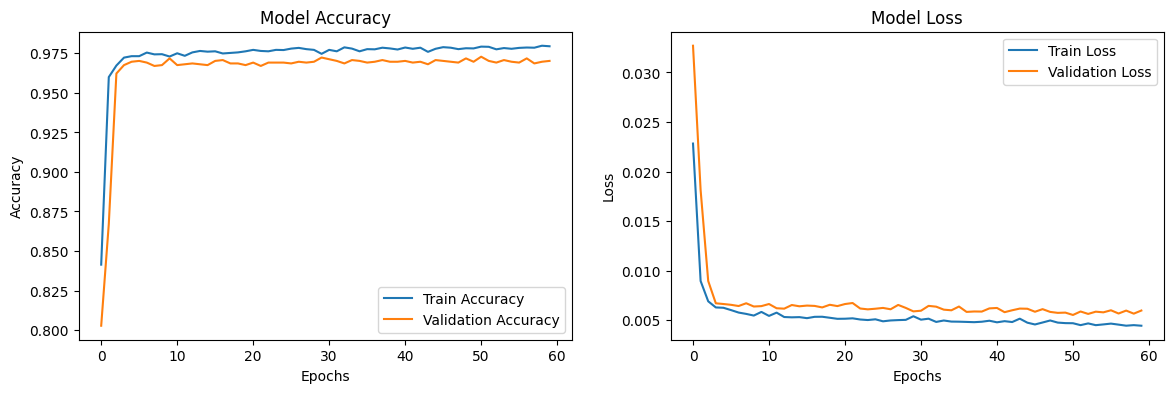

In [32]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy
ax1.plot(history.history["accuracy"], label="Train Accuracy")
ax1.plot(history.history["val_accuracy"], label="Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Accuracy")
ax1.legend()

# Loss
ax2.plot(history.history["loss"], label="Train Loss")
ax2.plot(history.history["val_loss"], label="Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Model Loss")
ax2.legend()

### Graph Interpretation

The graphs show how well the model is learning over 60 training epochs. In the **accuracy graph**, both training and validation accuracy improve quickly at first and then level off. The model reaches about **98% accuracy on training data** and **97% on validation data**, meaning it's learning well but does slightly better on training data.

In the **loss graph**, the loss start high but drop quickly, showing that the model is improving. Training loss is a little lower than validation loss, which means the model may be **slightly overfitting**—doing better on training data than on new data.

# Conclusion

In this project, we trained a model and saw that it learned well, reaching high accuracy for both training and validation data. The loss also dropped quickly, showing that the model improved over time. However, the small gap between training and validation results suggests slight overfitting, meaning the model does a little better on training data than new data. To improve, we could try techniques like regularization to make it more balanced. Overall, the model performs well and can be useful, but small tweaks could make it even better.